---
title: Uses of the Periodogram
---

The periodogram has the following uses: 

1. If we want to use the single sinusoidal model: $y_t = \beta_0 + \beta_1 \cos(2 \pi f t) + \beta_2 \sin(2 \pi f t) + \epsilon_t$, the periodogram gives a computationally efficient method to calculate $RSS(f)$ at Fourier frequencies $f$. This is very useful when the sample size $n$ is large. 
2. The periodogram is an exploratory tool that can suggest useful models to fit to the data. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import librosa


An example for the first application is the following (we already saw this application in Lecture 6). Here the dataset represents the sound waveform for an audio file. 

## Audio Data

In [3]:
y,sr=librosa.load("Hear Piano Note - Middle C.mp3")
n = len(y)
print(n)
print(sr) #sr represents the sampling ratio (this is the number of datapoints for 1 second of audio)
print(n/sr)

301272
22050
13.66312925170068


Text(0, 0.5, 'Sound waverform')

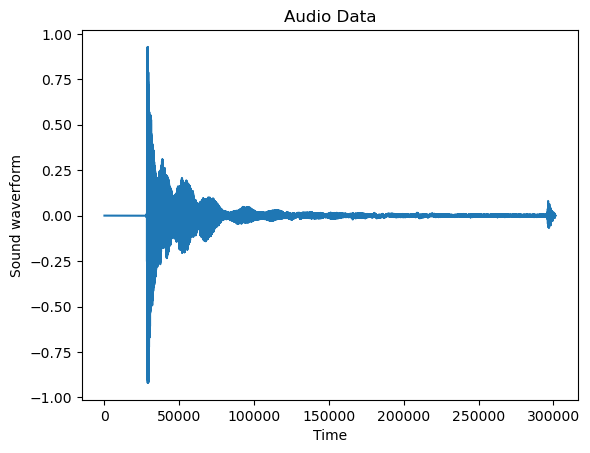

In [4]:
plt.plot(y)
plt.xlabel('Time')
plt.title('Audio Data')
plt.ylabel('Sound waverform')

The full plot of the data is not very revealing as the data size is very long. But if we restrict to a smaller portion of the dataset, we can visualize the cyclical behavior more easily. 

Text(0, 0.5, 'Sound waveform')

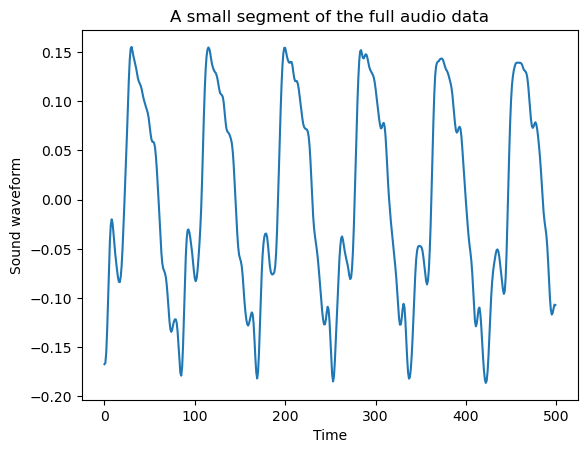

In [5]:
y_smallpart = y[50000:(50000 + 500)]
plt.plot(y_smallpart)
plt.xlabel('Time')
plt.title('A small segment of the full audio data')
plt.ylabel('Sound waveform')

Let us fit the single sinusoidal model: $y_t = \beta_0 + \beta_1 \cos(2 \pi f t) + \beta_2 \sin(2 \pi f t) + \epsilon_t$ to this dataset to figure out the best fitting $f$ parameter. Here, in order to compute 
\begin{equation*}
    RSS(f) := \argmin_{\beta_0, \beta_1, \beta_2} \sum_{i=1}^n (y_t - \beta_0 - \beta_1 \cos(2 \pi f t) - \beta_2 \sin(2 \pi f t))^2,
\end{equation*}
we have to rely on the periodogram. This method will calculate $RSS(f)$ at the Fourier frequencies very quickly using the connection between $RSS(f)$, the periodogram and the DFT. 
\begin{equation*}
   RSS(j/n) = \sum_t (y_t - \bar{y})^2 - 2 I(j/n) ~~ \text{ and } ~~ I(j/n) = \frac{|b_j|^2}{n} ~~ \text{ with }~~ b_j = \sum_t y_t \exp(- 2 \pi i j t/n)
\end{equation*}

In [6]:
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    return fourier_freqs, pgram_y


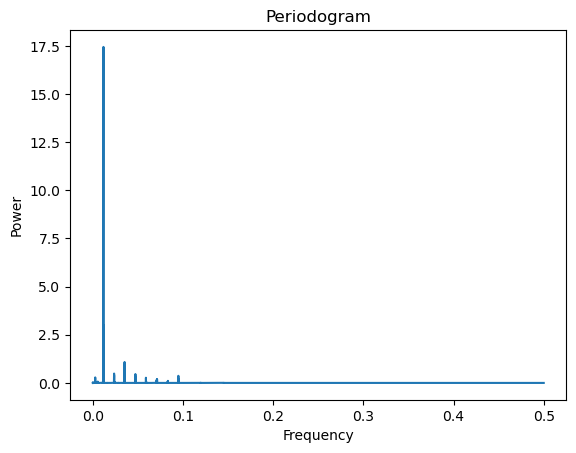

In [7]:
freqs, pgram = periodogram(y)
plt.plot(freqs, pgram)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Periodogram')
plt.show()

In [8]:
def rss_periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, 1/2, 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    var_y = np.sum((y - np.mean(y)) ** 2)
    rssvals = var_y - 2*pgram_y
    return fourier_freqs, rssvals

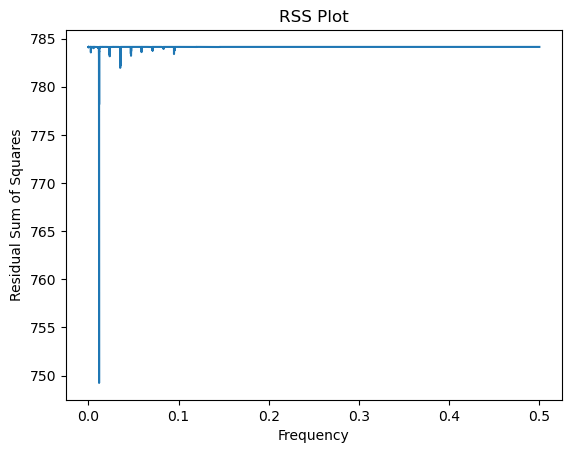

In [9]:
freqs, rssvals = rss_periodogram(y)
plt.plot(freqs, rssvals)
plt.xlabel('Frequency')
plt.ylabel('Residual Sum of Squares')
plt.title('RSS Plot')
plt.show()

In [10]:
#Now we estimate the frequency parameter f in the single sinusoidal model: 
fhat = freqs[np.argmax(pgram)]
print(fhat)
#To get the frequency in Hertz (which is the number of cycles in one sec)
print(fhat * sr)
#This is quite close to the Middle C frequency (261.625565 Hertz) on the piano

0.011799968135107147
260.1892973791126


For Bayesian uncertainty quantification, we use the posterior: 
\begin{equation*}
   I\{0 \leq f \leq 1/2\} |X_f^T X_f|^{-1/2} \left(\frac{1}{RSS(f)} \right)^{(n-p)/2}
\end{equation*}
where $p = 3$ and $|X_f^T X_f|$ denotes the determinant of $X_f^T X_f$. When $f$ is a Fourier frequency (between 0 and 1/2), we have seen that 
\begin{equation*}
   X_f^T X_f = \begin{pmatrix} n & 0 & 0 \\ 0 & n/2 & 0 \\ 0 & 0 & n/2 \end{pmatrix} 
\end{equation*}
which means that $X_f^T X_f$ does not depend on $f$ (as long as $f$ is a Fourier frequency strictly between 0 and 0.5). For such frequencies, we can drop the $|X_f^T X_f|^{-1/2}$ term from the posterior and we are left with the following simpler formula for the posterior: 
\begin{equation*}
   I\{0 < f < 0.5 \text{ is a Fourier frequency}\} \left(\frac{1}{RSS(f)} \right)^{(n-p)/2}
\end{equation*}

In [11]:
#Uncertainty quantification for f: 
def logpost_periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, (1/2) + (1/n), 1/n)
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m+1]) ** 2)/n
    var_y = np.sum((y - np.mean(y)) ** 2)
    rssvals = var_y - 2*pgram_y
    p = 3
    logpostvals = ((p-n)/2) * np.log(rssvals)
    return fourier_freqs, logpostvals

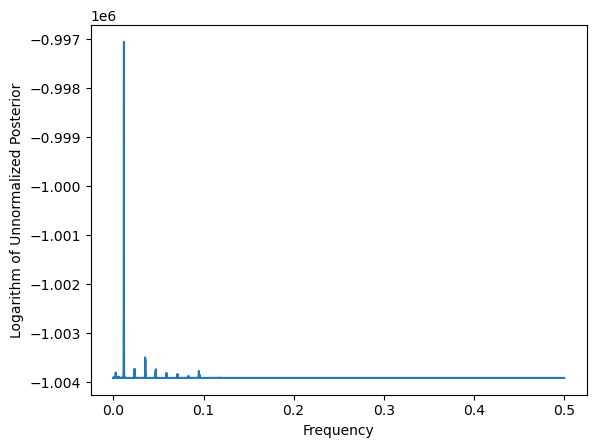

In [12]:
freqs, logpostvals = logpost_periodogram(y)
plt.plot(freqs, logpostvals)
plt.xlabel('Frequency')
plt.ylabel('Logarithm of Unnormalized Posterior')
plt.show()

Next we exponentiate the log posterior values to compute the posterior.

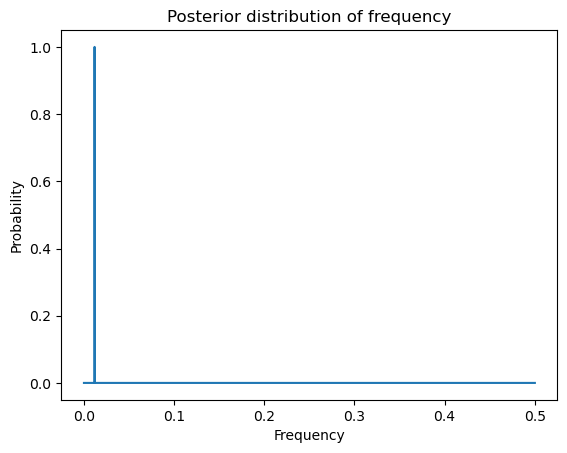

In [13]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized/(np.sum(postvals_unnormalized))
plt.plot(freqs, postvals)
plt.xlabel('Frequency')
plt.ylabel('Probability')
plt.title('Posterior distribution of frequency')
plt.show()

Credible intervals for $f$ can be obtained as follows. 

In [14]:
def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m)])
    return(ans)
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m+1
est_ind = np.argmax(postvals)
f_est = freqs[est_ind]
#95% credible interval for f:
ci_f_low = freqs[est_ind - m]
ci_f_high = freqs[est_ind + m]
print(np.array([f_est, ci_f_low, ci_f_high]))
#Uncertainty estimate in Hertz:
f_est_hz = f_est * sr
ci_f_low_hz = ci_f_low * sr
ci_f_high_hz = ci_f_high * sr
print(np.array([f_est_hz, ci_f_low_hz, ci_f_high_hz]))

[0.01179997 0.01179665 0.01180329]
[260.18929738 260.1161077  260.26248705]


## Sunspots Dataset

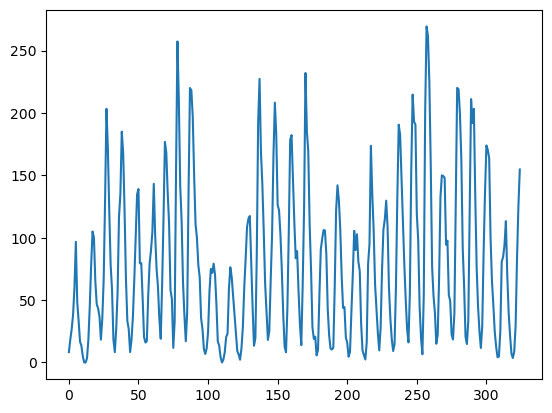

In [15]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
y = sunspots.iloc[:,1].values
plt.plot(y)
plt.show()

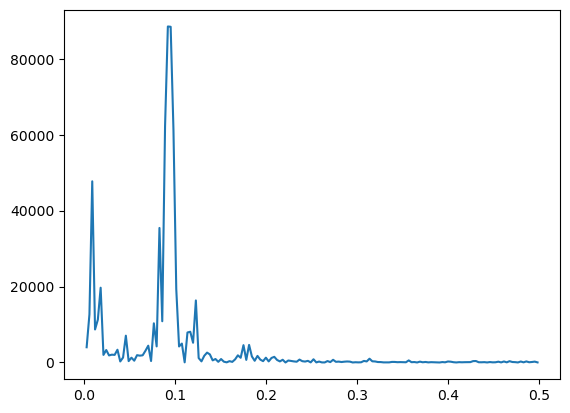

In [23]:
freqs, pgram = periodogram(y)
plt.plot(freqs, pgram)
plt.show()

In [17]:
#Estimate of f and the corresponding period: 
fhat = freqs[np.argmax(pgram)]
period_hat = 1/fhat
print(period_hat)

10.833333333333334


In [18]:
freqs, logpostvals = logpost_periodogram(y)
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized/(np.sum(postvals_unnormalized))

def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m)])
    return(ans)
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m+1
est_ind = np.argmax(postvals)
f_est = freqs[est_ind]
#95% credible interval for f:
ci_f_low = freqs[est_ind - m]
ci_f_high = freqs[est_ind + m]
print(np.array([f_est, ci_f_low, ci_f_high]))

period_est = 1/f_est
ci_period_low = 1/ci_f_high
ci_period_high = 1/ci_f_low
print(np.array([ci_period_low, period_est, ci_period_high]))


[0.09230769 0.08615385 0.09846154]
[10.15625    10.83333333 11.60714286]


In [259]:
np.array([(period_est - ci_period_low)*365, (ci_period_high - period_est)*365])

array([247.13541667, 282.44047619])

The point estimate and the credible interval can be summarized as: 
\begin{equation*}
   [10.83 \text{ years } - 247 \text{ days }, 10.83 \text{ years } + 282 \text{ days }]
\end{equation*}

Here we are losing something in doing the analysis through Fourier frequencies. If we instead use a much finer grid of frequencies, we will get a much narrower uncertainty for $f$ and the period. 

In [19]:
def logpost(f):
    n = len(y)
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    p = X.shape[1]
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) #sgn gives the sign of the determinant (in our case, this should 1)
    #log_det gives the logarithm of the absolute value of the determinant
    logval = ((p-n)/2) * np.log(rss) - (0.5)*log_det
    return logval

allfvals = np.arange(0.01, 0.5, .0001) #much finer grid
logpostvals = np.array([logpost(f) for f in allfvals])
postvals = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals/(np.sum(postvals))
print(allfvals[np.argmax(postvals)])
print(1/allfvals[np.argmax(postvals)])


0.09089999999999951
11.00110011001106


In [20]:
def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m)])
    return(ans)
m = 0
while PostProbAroundMax(m) <= 0.95:
    m = m+1
est_ind = np.argmax(postvals)
f_est = allfvals[est_ind]
#95% credible interval for f:
ci_f_low = allfvals[est_ind - m]
ci_f_high = allfvals[est_ind + m]
print(np.array([f_est, ci_f_low, ci_f_high]))

period_est = 1/f_est
ci_period_low = 1/ci_f_high
ci_period_high = 1/ci_f_low
print(np.array([ci_period_low, period_est, ci_period_high]))

[0.0909 0.0906 0.0912]
[10.96491228 11.00110011 11.03752759]


In [21]:
np.array([(period_est - ci_period_low)*365, (ci_period_high - period_est)*365])

array([13.2085577 , 13.29603159])

So the uncertainty period can be summarized as:
\begin{equation*}
   [11 \text{ years } - 13.2 \text{ days}, 11 \text{ years } + 13.3 \text{ days}]
\end{equation*}
which is much narrower compared to the previous estimate of the period based only on Fourier frequencies. 

### Fitting two sinusoids to the sunspots data

The periodogram can be used to suggest other models for the data. For the sunspots, the periodogram shows another frequency (which is much smaller than the 1/11 frequency) also has stronger power compared to its neighboring frequency. This might suggests the model:
\begin{equation*}
  y_t = \beta_0 + \beta_1 \cos(2 \pi f_1 t) + \beta_2 \sin(2 \pi f_1 t) + \beta_3 \cos(2 \pi f_2 t) + \beta_4 \sin(2 \pi f_2 t) + \epsilon_t
\end{equation*}
with both $f_1$ and $f_2$ denoting unknown parameters (along with $\beta_0, \beta_1, \beta_2, \beta_3, \beta_4$ and $\sigma$).

[4.01088439e+03 1.26974867e+04 4.77297930e+04 8.70355431e+03
 1.12773110e+04 1.97012775e+04 1.99517379e+03 3.27980926e+03
 1.85999321e+03 2.05650593e+03 2.00187676e+03 3.35780063e+03
 2.70593790e+02 1.30319204e+03 7.06065964e+03 3.59682320e+02
 1.26206651e+03 4.71775939e+02 1.92275157e+03 1.79871306e+03
 1.89084747e+03 3.08964635e+03 4.42531690e+03 3.87102917e+02
 1.03191298e+04 4.23538290e+03 3.54415717e+04 1.08635660e+04
 6.23020333e+04 8.85252845e+04 8.84452519e+04 6.12489810e+04
 1.93441390e+04 4.21905730e+03 4.98195377e+03 3.85342684e+01
 7.89981650e+03 8.09772100e+03 5.20200317e+03 1.63452492e+04
 1.16651003e+03 2.95753013e+02 1.76392645e+03 2.59952918e+03
 2.12652083e+03 5.58100806e+02 9.14876776e+02 1.74020095e+02
 9.06805007e+02 2.11113310e+02 3.53243443e+01 3.48589976e+02
 1.57175530e+02 8.13281407e+02 1.88543436e+03 1.23676189e+03
 4.56802465e+03 6.78280638e+02 4.63319403e+03 1.59216745e+03
 4.50686809e+02 1.72894893e+03 7.59341336e+02 3.49550991e+02
 1.26903926e+03 2.795193

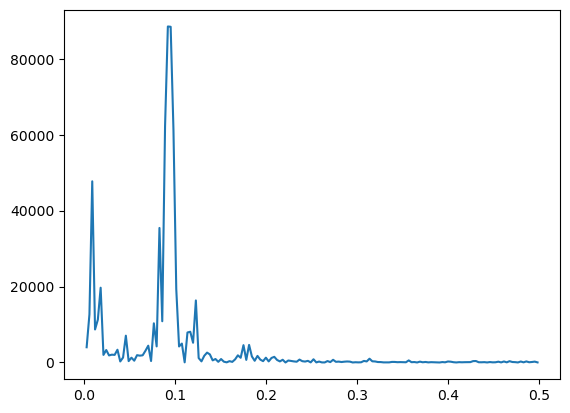

In [24]:
freqs, pgram = periodogram(y)
plt.plot(freqs, pgram)
print(pgram)

We can try to fit two sinusoids (at $f_1 = 1/11$ and $f_2 = 3/n$ to the data) to see if we get an improved fit visually. 

In [27]:
n = len(y)
f1 = 1/11
x = np.arange(1, n+1)
xcos1 = np.cos(2 * np.pi * f1 * x)
xsin1 = np.sin(2 * np.pi * f1 * x)
X = np.column_stack([np.ones(n), xcos1, xsin1])
md1 = sm.OLS(y, X).fit()

f2 = 3/n
xcos2 = np.cos(2 * np.pi * f2 * x)
xsin2 = np.sin(2 * np.pi * f2 * x)
X = np.column_stack([np.ones(n), xcos1, xsin1, xcos2, xsin2])
md2 = sm.OLS(y, X).fit()



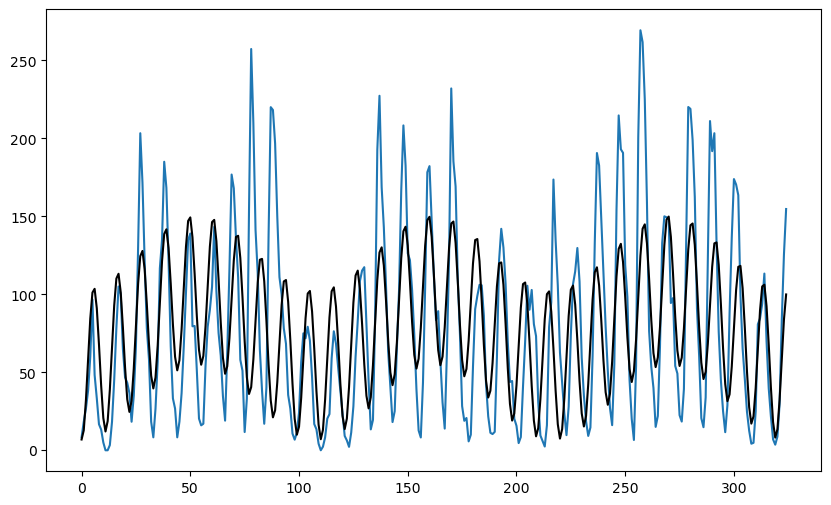

In [28]:
plt.figure(figsize = (10, 6))
#plt.plot(y, linestyle = '', marker = '')
plt.plot(y)
plt.plot(md1.fittedvalues, color = 'red', marker = '', linestyle = '')
plt.plot(md2.fittedvalues, color = 'black')
plt.show()

The fit seems to have improved compared to the single sinusoid model. Let us now try to find the best $f_1$ and $f_2$ for the two sinusoid model using a grid search to minimize the RSS. The function for RSS is given below. 

In [30]:
def rss(f):
    n = len(y)
    x = np.arange(1, n+1)
    f1 = f[0]
    xcos1 = np.cos(2 * np.pi * f1 * x)
    xsin1 = np.sin(2 * np.pi * f1 * x)
    f2 = f[1]
    xcos2 = np.cos(2 * np.pi * f2 * x)
    xsin2 = np.sin(2 * np.pi * f2 * x)
    X = np.column_stack([np.ones(n), xcos1, xsin1, xcos2, xsin2])
    md = sm.OLS(y, X).fit()
    ans = np.sum(md.resid ** 2)
    return ans

#As examples, consider the following RSS values:
print(rss(np.array([1/11, 2/n])))
print(rss(np.array([1/11, 3/n])))


841338.0869793112
772463.5063723011


Now we do grid search to find the best $f_1$ and $f_2$ which fit the data. The intervals over which the grids need to be placed should be chosen carefully. Here I am using the intuition (based on the periodogram) that $f_1$ is the main frequency which should be around 1/11, and $f_2$ should be much smaller (the periodogram's first peak was at $3/n$).

In [31]:
f1_gr = np.linspace(0.05, 0.15, 300)
f2_gr = np.linspace(1/n, 4/n, 300)
X, Y = np.meshgrid(f1_gr, f2_gr)
g = pd.DataFrame({'x': X.flatten(), 'y': Y.flatten()})

g['z'] = g.apply(lambda row: rss([row['x'], row['y']]), axis = 1)


The best $f_1$ and $f_2$ which minimize the RSS over the chosen grid can be obtained as follows. 

In [33]:
min_row = g.loc[g['z'].idxmin()]
print(min_row)
f_opt = np.array([min_row['x'], min_row['y']])
print(f_opt)

x         0.090803
y         0.009931
z    758772.699688
Name: 66722, dtype: float64
[0.09080268 0.00993054]


We can fit the two sinusoid model with these $f_1$ and $f_2$ and look at the fitted values. 

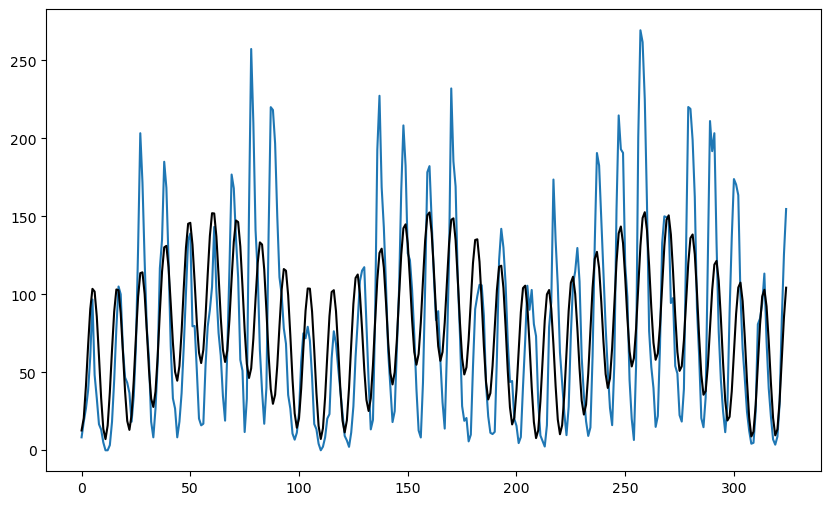

In [34]:
n = len(y)
f1 = f_opt[0]
x = np.arange(1, n+1)
xcos1 = np.cos(2 * np.pi * f1 * x)
xsin1 = np.sin(2 * np.pi * f1 * x)
X = np.column_stack([np.ones(n), xcos1, xsin1])
md1 = sm.OLS(y, X).fit()

f2 = f_opt[1]
xcos2 = np.cos(2 * np.pi * f2 * x)
xsin2 = np.sin(2 * np.pi * f2 * x)
X = np.column_stack([np.ones(n), xcos1, xsin1, xcos2, xsin2])
md2 = sm.OLS(y, X).fit()

plt.figure(figsize = (10, 6))
#plt.plot(y, linestyle = '', marker = '')
plt.plot(y)
plt.plot(md1.fittedvalues, color = 'red', marker = '', linestyle = '')
plt.plot(md2.fittedvalues, color = 'black')
plt.show()

### Fitting three sinusoids to the sunspots data

We now fit three sinusoids to the sunspots data. The following is the function for computing the RSS. Here $f$ represents a possible array containing multiple frequencies. 

In [36]:
def rss(f):
    n = len(y)
    X = np.column_stack([np.ones(n)])
    x = np.arange(1, n+1)
    if np.isscalar(f):
        f = [f]
    for j in range(len(f)):
        f1 = f[j]
        xcos = np.cos(2 * np.pi * f1 * x)
        xsin = np.sin(2 * np.pi * f1 * x)
        X = np.column_stack([X, xcos, xsin])
    md = sm.OLS(y, X).fit()
    ans = np.sum(md.resid ** 2)
    return ans


We need to place three grids for the three frequency parameters. Again, the ranges for the three grids need to be carefully chosen. 

In [37]:
#Searching for the three best frequencies (will be computationally intensive):
f1_gr = np.linspace(1/12, 1/9, 50)
f2_gr = np.linspace(1/n, 4/n, 50)
f3_gr = np.linspace(0.09, 0.12, 50)
X, Y, Z = np.meshgrid(f1_gr, f2_gr, f3_gr)
g = pd.DataFrame({'x': X.flatten(), 'y': Y.flatten(), 'z': Z.flatten()})

g['rss'] = g.apply(lambda row: rss([row['x'], row['y'], row['z']]), axis = 1)

In [38]:
min_row = g.loc[g['rss'].idxmin()]
print(min_row)
f_opt = np.array([min_row['x'], min_row['y'], min_row['z']])
print(f_opt)

x           0.090703
y           0.010047
z           0.099796
rss    595011.787595
Name: 93166, dtype: float64
[0.09070295 0.0100471  0.09979592]


Below, we fit the three sinusoid model with $f$ chosen as the grid-based minimizer above. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     57.82
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           4.13e-48
Time:                        23:30:21   Log-Likelihood:                -1681.9
No. Observations:                 325   AIC:                             3378.
Df Residuals:                     318   BIC:                             3404.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.8124      2.412     33.506      0.0

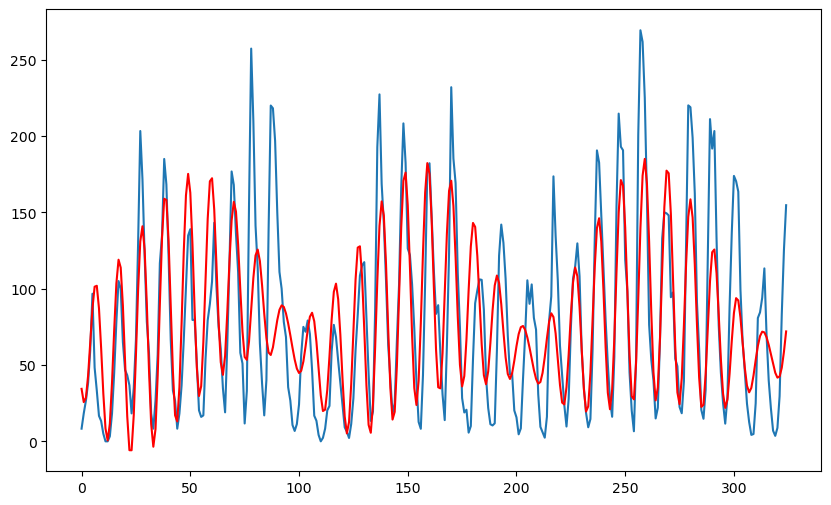

In [39]:
rss(np.array([1/11, 0.009, 0.1]))
n = len(y)
f = f_opt #f_opt was obtained from the grid minimization
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n)])
x = np.arange(1, n+1)
if np.isscalar(f):
    f = [f]
for j in range(len(f)):
    f1 = f[j]
    xcos = np.cos(2 * np.pi * f1 * x)
    xsin = np.sin(2 * np.pi * f1 * x)
    X = np.column_stack([X, xcos, xsin])

md = sm.OLS(y, X).fit()
print(md.summary())

plt.figure(figsize = (10, 6))
#plt.plot(y, linestyle = '', marker = '')
plt.plot(y)
plt.plot(md1.fittedvalues, color = 'red', marker = '', linestyle = '')
plt.plot(md2.fittedvalues, color = 'black', marker = '', linestyle = '')
plt.plot(md.fittedvalues, color = 'red')
plt.show()